# Analying metadata of posters on Zenodo and Figshare

## Imports

In [1]:
import json
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib.patches import Patch

In [2]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0", "#118ab2", "#ef476f", "#fb5607"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]
markers = ["o", "s", "D", "^", "v", "*", "X", "+", "p", "h"]

## Get poster record from repositories [Can be skipped output files are already in the dataset]

Get a list of all the posters along with their metadata from Zenodo and Figshare (posters published on the repositories as of December 31, 2024).
Note: The output of these functions are included in the dataset associated with this work

### Get poster record from Zenodo

#### Get record

In [3]:
# token
zenodo_access_token = os.getenv("ZENODO_ACCESS_TOKEN")

In [9]:
# Zenodo doesn't return more than 10k results per request so need to break down into date ranges with less than 10k posters created each
date_range_list = [
    "{* TO 2020-12-31]",
    "[2021-01-01 TO 2022-12-31]",
    "[2023-01-01 TO 2024-12-31]",
]

all_results = []
for date_range in date_range_list:

    increment_page = True
    page = 0

    while increment_page:
        page += 1
        params = {
            "resource_type": "poster",
            "q": "created:" + date_range,
            "status": "published",
            "sort": "mostrecent",
            "all_versions": "false",
            "size": 300,
            "page": page,
            "access_token": zenodo_access_token,
        }
        response = requests.get(
            "https://zenodo.org/api/records",
            params=params,
        )

        if response.status_code == 200:
            r = response.json()
            if r["hits"]["hits"]:

                results = r["hits"]["hits"]

                for result in results:
                    all_results.extend(hits)
                    count += 1
            else:
                print("No more pages", response.status_code, str(page))
                increment_page = False

        else:
            print("Error", response.status_code, response.content, str(page))
            increment_page = False
print(str(len(all_results)), "poster records found on Zenodo as of December 31, 2024")

out_path = "outputs/records/zenodo.ndjson"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with open(out_path, "w", encoding="utf-8") as f:
    for rec in all_results:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved Zenodo record")

No more pages 200 26
No more pages 200 27
No more pages 200 34
24751 posters were published on Zenodo as of December 31, 2024


#### Verify results (all records are unique and are posters)

In [18]:
# Load data
results = []
with open("outputs/repository-records/zenodo.ndjson", "r", encoding="utf-8") as f:
    for line in f:
        results.append(json.loads(line))

In [19]:
# View a record
display(results[0])

{'created': '2020-12-31T17:47:25.041391+00:00',
 'modified': '2024-07-19T11:12:40.105840+00:00',
 'id': 4407772,
 'conceptrecid': '4407771',
 'doi': '10.5281/zenodo.4407772',
 'conceptdoi': '10.5281/zenodo.4407771',
 'doi_url': 'https://doi.org/10.5281/zenodo.4407772',
 'metadata': {'title': 'Deep Learning-based Object Detection for a Quality Control Application in the Sterilization Unit of a Hospital',
  'doi': '10.5281/zenodo.4407772',
  'publication_date': '2020-11-26',
  'description': '<p>Machine vision systems are emerging as increasingly popular solutions in automated quality and process control applications. By allowing non-contact, and therefore non-destructive inspection, techniques based on machine vision are especially suitable when correct handling of the object under inspection is critical. This is the quality control problem that we address in this work: it consists of the detection of a series of control elements that are placed in boxes and bags that contain the surgic

In [20]:
# Verifications
total_records = len(results)

ids = []
missing_id_count = 0
total_posters = 0
for v in results:
    id_ = v.get("id")
    metadata = v.get("metadata") or {}
    resource_type = (metadata.get("resource_type") or {}).get("title")
    if id_ is None:
        missing_id_count += 1
    else:
        ids.append(id_)
    if resource_type == "Poster":
        total_posters += 1
        

unique_ids = len(set(ids))
duplicate_entries = len(ids) - unique_ids

print(f"Total records: {total_records}")
print(f"Total records with resource type poster: {total_posters}")
print(f"Unique records: {unique_ids}")
print(f"Non poster records: {total_records-total_posters}")
print(f"Records with missing id: {missing_id_count}")
print(f"Duplicate Records (based on id): {duplicate_entries}")

if(
    total_records == total_posters == unique_ids
    and (total_records - total_posters) == 0
    and missing_id_count == 0
    and duplicate_entries == 0
):
    print("All records are posters with unique IDs - clear to continue.")
else:
    print("Data sanity check failed - review counts above.")

Total records: 24751
Total records with resource type poster: 24751
Unique records: 24751
Non poster records: 0
Records with missing id: 0
Duplicate Records (based on id): 0
All records are posters with unique IDs - clear to continue.


#### Notes:  
- Role of researchers are not shown on the online record or the api record: why ask it?
- Additional dates: The dates are shown in the online record but not included in the api record, why?
- publication_date: provided by user
- creation_date: date when the record was created (since we are only looking at the latest version, this is the creation date of the latest version)

### Get posters metadata from Figshare

#### Token and base url

In [3]:
figshare_access_token = os.getenv("FIGSHARE_ACCESS_TOKEN_POSTER")
BASE_URL = "https://api.figshare.com/v2"

#### Get summary records of all posters

In [37]:
summaries = []

# Date ranges to handle pagination limits
date_ranges = [
    {"after": "2012-01-01", "before": "2020-12-31"},
    {"after": "2021-01-01", "before": "2024-12-31"}
]

for period in date_ranges:
    page = 1
    while True:
        search_query = f":item_type: poster AND :posted_after: {period['after']} AND :posted_before: {period['before']}"
        
        payload = {
            "search_for": search_query,
            "page_size": 1000,
            "page": page
        }
        
        response = requests.post(f"{BASE_URL}/articles/search", json=payload)
        
        if response.status_code != 200:
            print(f"API Error: {response.status_code}")
            break
            
        data = response.json()
        if not data:
            break
            
        summaries.extend(data)
        print(f"Fetched {len(data)} items for period starting {period['after']} (Page {page})")
        
        page += 1
        time.sleep(0.5)

print(f"\nDone! Total record summaries found: {len(summaries)}")
filename = "outputs/repository-records/figshare-summaries.json"

with open(filename, "w", encoding="utf-8") as f:
    json.dump(summaries, f, ensure_ascii=False, indent=2)

print(f"Success! Saved {len(summaries)} record summaries to {filename}")

#### Verify results (all records are unique and are posters)

In [4]:
# load data
with open("outputs/repository-records/figshare-summaries.json", "r", encoding="utf-8") as f:
    results = json.load(f)

In [5]:
# view a record
results[0]

{'project_id': None,
 'id': 24736404,
 'title': 'Beyond Tradition: Rethinking Early Modern Europe',
 'doi': '10.7274/24736404.v1',
 'handle': '',
 'url': 'https://api.figshare.com/v2/articles/24736404',
 'published_date': '2016-03-31T00:00:00Z',
 'thumb': 'https://s3-eu-west-1.amazonaws.com/figshare-production-eu-nd-previews9481-eu-west-1/43566198/thumb.png',
 'defined_type': 5,
 'defined_type_name': 'poster',
 'group_id': 51396,
 'url_private_api': 'https://api.figshare.com/v2/account/articles/24736404',
 'url_public_api': 'https://api.figshare.com/v2/articles/24736404',
 'url_private_html': 'https://figshare.com/account/articles/24736404',
 'url_public_html': 'https://curate.nd.edu/articles/poster/Beyond_Tradition_Rethinking_Early_Modern_Europe/24736404',
 'timeline': {'posted': '2016-03-31T00:00:00',
  'firstOnline': '2016-03-31T00:00:00'},
 'resource_title': '',
 'resource_doi': '',
 'created_date': '2023-12-09T00:11:47Z',
 'modified_date': '2024-08-30T19:37:01Z'}

In [6]:
# Verifications
total_records = len(results)
ids = []
missing_id_count = 0
total_posters = 0

for item in results:
    id_ = item.get("id")
    resource_type = item.get("defined_type_name")
    
    if id_ is None:
        missing_id_count += 1
    else:
        ids.append(id_)
    
    if resource_type == "poster":
        total_posters += 1

unique_ids_count = len(set(ids))
duplicate_entries = len(ids) - unique_ids_count

print(f"Total records: {total_records}")
print(f"Total records with resource type poster: {total_posters}")
print(f"Unique records: {unique_ids_count}")
print(f"Non poster records: {total_records - total_posters}")
print(f"Records with missing id: {missing_id_count}")
print(f"Duplicate Records (based on id): {duplicate_entries}")

if (
    total_records == total_posters == unique_ids_count
    and (total_records - total_posters) == 0
    and missing_id_count == 0
    and duplicate_entries == 0
):
    print("All records are posters with unique IDs - clear to continue.")
else:
    print("Data sanity check failed - review counts above.")

Total records: 14513
Total records with resource type poster: 14513
Unique records: 14513
Non poster records: 0
Records with missing id: 0
Duplicate Records (based on id): 0
All records are posters with unique IDs - clear to continue.


#### Get full metadata

In [ ]:
INPUT_FILE = "outputs/repository-records/figshare-summaries.json"
OUTPUT_FILE = "outputs/repository-records/figshare-metadata.ndjson"

# Load target IDs
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    summaries = json.load(f)
all_ids = set(item["id"] for item in summaries if item.get("id"))

# Check for existing progress if any
processed_ids = set()
if os.path.exists(OUTPUT_FILE):
    with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
        for line in f:
            try:
                record = json.loads(line)
                processed_ids.add(record["id"])
            except json.JSONDecodeError:
                continue
    print(f"{len(processed_ids)} posters records already in local storage")
else:
    print("Starting fresh harvest")

# Determine ids to run for this session
ids_to_fetch = list(all_ids - processed_ids)
total_to_fetch = len(ids_to_fetch)
session_processed_count = 0

print(f"Queueing {total_to_fetch} new posters for metadata harvesting")

headers = {"Authorization": f"token {figshare_access_token}"}

# Harvest metadata (save on the go)
with open(OUTPUT_FILE, "a", encoding="utf-8") as ndjson_file:
    for figshare_id in ids_to_fetch:
        success = False
        
        while not success:
            try:
                r = requests.get(f"{BASE_URL}/articles/{figshare_id}", headers=headers)
                
                if r.status_code == 200:
                    metadata = r.json()
                    ndjson_file.write(json.dumps(metadata) + "\n")
                    session_processed_count += 1
                    
                    if session_processed_count % 100 == 0:
                        print(f"\rProgress: {session_processed_count}/{total_to_fetch} new items saved...", end="", flush=True)
                    
                    success = True # Exit the while loop move to next ID
                    time.sleep(5) # polite delay

                elif r.status_code in [403, 429]:
                    wait_time = 300  # 5 minutes wait if 429 forbidden or 429 rate limit then try again same id
                    print(f"\n[Status {r.status_code}] Rate limited. Sleeping for 5 minutes...")
                    time.sleep(wait_time)
                    print("Resuming...")
                    # success remains False

                elif r.status_code == 404:
                    print(f"\n[Warning] ID {figshare_id} not found (404). Skipping.")
                    success = True # Move on so we are not stuck on a dead link

                else:
                    print(f"\n[Error] ID {figshare_id} returned {r.status_code}. Retrying in 10s...")
                    time.sleep(10)

            except Exception as e:
                print(f"\n[Connection Error] {e}. Retrying in 30s...")
                time.sleep(30)

# Summary
total_final_count = len(processed_ids) + session_processed_count
print(f"Run Complete!")
print(f"Posters processed in this run: {session_processed_count}")
print(f"Total posters now in file:     {total_final_count}")

68 posters records already in local storage
Queueing 14445 new posters for metadata harvesting

[Status 403] Rate limited. Sleeping for 5 minutes...


#### Get stats

In [ ]:
STATS_URL = "https://stats.figshare.com/total"
INPUT_METADATA_FILE = "outputs/repository-records/figshare-metadata.ndjson"
OUTPUT_ENRICHED_FILE = "outputs/repository-records/figshare.ndjson"

# Load target metadata records to get the IDs of all posters
all_metadata = []
if os.path.exists(INPUT_FILE):
    with open(INPUT_FILE, "r", encoding="utf-8") as f:
        for line in f:
            all_metadata.append(json.loads(line))
    all_ids = {item["id"] for item in all_metadata}
else:
    print(f"Error: {INPUT_FILE} not found. Run metadata harvest first")
    sys.exit()

# Check for existing progress in the enriched file
processed_ids = set()
if os.path.exists(OUTPUT_FILE):
    with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
        for line in f:
            try:
                record = json.loads(line)
                processed_ids.add(record["id"])
            except json.JSONDecodeError:
                continue
    print(f"{len(processed_ids)} enriched records already output file")
else:
    print("Starting fresh stats harvest")

# Determine records to run for this session
session_processed_count = 0
records_to_process = [m for m in all_metadata if m["id"] not in processed_ids]
total_to_fetch = len(records_to_process)

print(f"Queueing {total_to_fetch} posters for stats enrichment")

headers = {"Authorization": f"token {figshare_access_token}"}

# Harvest stats
with open(OUTPUT_FILE, "a", encoding="utf-8") as ndjson_file:
    for record in records_to_process:
        figshare_id = record["id"]
        try:
            stats = {}
            # Need two API endpoints for views and downloads for each ID
            for metric in ["views", "downloads"]:
                url = f"{STATS_URL}/{metric}/article/{figshare_id}"
                r = requests.get(url, headers=headers)
                
                if r.status_code == 200:
                    stats[metric] = r.json().get("totals", 0)
                elif r.status_code == 429:
                    print(f"\n[Rate Limit] Stats API throttled at {figshare_id}. Waiting 60s...")
                    time.sleep(60)
                    success = False # Flag that this record isn't valid yet
                    break 
                else:
                    print(f"\n[Error] {r.status_code} for {metric} on ID {figshare_id}")
                    success = False
                    break
            
            # Add stats to the existing metadata record
            record["stats"] = stats
            
            # Write to output file
            ndjson_file.write(json.dumps(record) + "\n")
            session_processed_count += 1
            
            if session_processed_count % 100 == 0:
                sys.stdout.write(f"\rProgress: {session_processed_count}/{total_to_fetch} new items saved...", end="", flush=True)
                sys.stdout.flush()
            
            # slight delay to be safe with the API
            time.sleep(0.5)

        except Exception as e:
            print(f"\nSkipping ID {figshare_id} due to error: {e}")
            continue

# Summary
total_final_count = len(processed_ids) + session_processed_count
print(f"\nRun Complete!")
print(f"Posters enriched in this run: {session_processed_count}")
print(f"Total enriched records now in file: {total_final_count}")

## Process records for metadata analysis

Transform the records from the repositories into a common tabular format to faciliate analysis. Both records from Zenodo and Figshare are mapped to a common metadata naming.

### Helper functions

In [26]:
def has_text(x):
    #Return True if x is a non-empty string after removing end whitespace
    return isinstance(x, str) and bool(x.strip())


def text_or_na(x):
    #Return a stripped string if x contains text otherwise return pandas NA.
    if has_text(x):
        return x.strip()
    return pd.NA


def int_or_na(x):
    #Return an integer value if x can be safely cast to int otherwise return pandas NA.
    #Useful for views/downloads
    if x is None or x is pd.NA:
        return pd.NA
    try:
        return int(x)
    except Exception:
        return pd.NA

def safe_len(x):
    #Return len(x) if x is a list or tuple, otherwise return 0
    return len(x) if isinstance(x, (list, tuple)) else 0

def finalize_df(df):
    
    bool_cols = [c for c in df.columns if c.startswith("has_") or c.startswith("is_")]
    count_cols = [c for c in df.columns if c.endswith("_count")]
    float_cols = [c for c in df.columns if c.endswith("_percentage")]
    str_cols = [
        "doi", "doi_url", "repository_url", "license_name",
        "creation_date", "other_dates", "files", "repository"
    ]
    year_cols = ["creation_year"]

    # Ensure columns exist
    for c in str_cols + bool_cols + count_cols + float_cols:
        if c not in df.columns:
            df[c] = pd.NA

    df[bool_cols] = df[bool_cols].astype("boolean")
    df[count_cols] = df[count_cols].astype("Int64")
    df[float_cols] = df[float_cols].astype("Float64")
    df[str_cols] = df[str_cols].astype("string")
    df[year_cols] = df[year_cols].astype("Int64")

    # views/downloads int
    for c in ["views", "downloads", "citations"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    return df

In [27]:
def row_initializer():
    # Starting default for each poster metadata row
    return {
        # identifiers, links
        "doi": pd.NA,
        "doi_url": pd.NA,
        "repository_url": pd.NA,

        # access
        "is_open_access": False,

        # authors
        "authors_count": 0,
        "authors_affiliation_count": 0,
        "authors_familyname_count": 0,
        "authors_givennames_count": 0,
        "authors_gnd_count": 0,
        "authors_name_count": 0,
        "authors_orcid_count": 0,
        "authors_affiliation_percentage": 0.0,
        "authors_orcid_percentage": 0.0,

        # fundind, journal, language, license
        "has_funding_info": False,
        "has_journal": False,
        "has_language": False,
        "has_license": False,
        "license_name": pd.NA,

        # keywords
        "keywords_freetext_count": 0,
        "keywords_controlled_vocabularies_count": 0,
        "total_keywords_count": 0,

        # conference metadata
        "has_conference_acronym": False,
        "has_conference_dates": False,
        "has_conference_place": False,
        "has_conference_session": False,
        "has_conference_session_part": False,
        "has_conference_title": False,
        "has_conference_website": False,

        # dates
        "has_creation_date": False,
        "creation_date": pd.NA,
        "creation_year": pd.NA,
        "other_dates_count": 0,
        "other_dates": pd.NA,

        # references / related materials
        "references_no_identifiers_count": 0,
        "references_with_identifiers_count": 0,
        "total_references_count": 0,

        # descriptive content
        "has_title": False,
        "has_version": False,
        "has_description": False,
        "description_words_count": 0,
        "description_characters_count": 0,

        # name of the files
        "files": pd.NA,

        # engagement metrics
        "views": pd.NA,
        "downloads": pd.NA,

        # provenance
        "repository": pd.NA,
    }

In [28]:
def normalize_zenodo_record(result):
    row = row_initializer()
    row["repository"] = "Zenodo"

    metadata = result.get("metadata")

    # identifiers / links
    row["doi"] = text_or_na(result.get("doi"))
    row["doi_url"] = text_or_na(result.get("doi_url"))
    links = result.get("links") or {}
    row["repository_url"] = text_or_na(links.get("self_html"))

    # access rights
    row["is_open_access"] = (metadata.get("access_right") == "open")

    # authors
    creators = metadata.get("creators") or []
    if isinstance(creators, list):
        row["authors_count"] = len(creators)
        for a in creators:
            if not isinstance(a, dict):
                continue
            if has_text(a.get("affiliation")): row["authors_affiliation_count"] += 1
            if has_text(a.get("familyname")): row["authors_familyname_count"] += 1
            if has_text(a.get("givennames")): row["authors_givennames_count"] += 1
            if has_text(a.get("gnd")): row["authors_gnd_count"] += 1
            if has_text(a.get("name")): row["authors_name_count"] += 1
            if has_text(a.get("orcid")): row["authors_orcid_count"] += 1

    if row["authors_count"] > 0:
        row["authors_affiliation_percentage"] = (
            row["authors_affiliation_count"] / row["authors_count"] * 100
        )
        row["authors_orcid_percentage"] = (
            row["authors_orcid_count"] / row["authors_count"] * 100
        )

    # funding, journal, language
    row["has_funding_info"] = safe_len(metadata.get("grants")) > 0
    row["has_journal"] = has_text(metadata.get("journal"))
    row["has_language"] = has_text(metadata.get("language"))

    # license
    lic = metadata.get("license") or {}
    lic_id = lic.get("id") if isinstance(lic, dict) else None
    lic_id = text_or_na(lic_id)
    row["has_license"] = (lic_id is not pd.NA)
    row["license_name"] = lic_id

    # keywords
    row["keywords_freetext_count"] = safe_len(metadata.get("keywords"))
    row["keywords_controlled_vocabularies_count"] = safe_len(metadata.get("subjects"))
    row["total_keywords_count"] = safe_len(metadata.get("subjects"))


    # conference metadata
    meeting = metadata.get("meeting") or {}
    if isinstance(meeting, dict):
        row["has_conference_acronym"] = has_text(meeting.get("acronym"))
        row["has_conference_dates"] = has_text(meeting.get("dates"))
        row["has_conference_place"] = has_text(meeting.get("place"))
        row["has_conference_session"] = has_text(meeting.get("session"))
        row["has_conference_session_part"] = has_text(meeting.get("session_part"))
        row["has_conference_title"] = has_text(meeting.get("title"))
        row["has_conference_website"] = has_text(meeting.get("url"))

    # dates
    created = text_or_na(result.get("created"))
    row["creation_date"] = created
    row["has_creation_date"] = (created is not pd.NA)
    if pd.notna(created):
        year = pd.to_datetime(created, errors="coerce", utc=True).year
    else:
        year = pd.NA
    row["creation_year"] = year

    dates = metadata.get("dates") or []
    if isinstance(dates, list) and len(dates) > 0:
        row["other_dates_count"] = len(dates)
        row["other_dates"] = "; ".join(str(d) for d in dates)

    # references / related identifiers
    row["references_no_identifiers_count"] = safe_len(metadata.get("references"))
    row["references_with_identifiers_count"] = safe_len(metadata.get("related_identifiers"))
    row["total_references_count"] = safe_len(metadata.get("references")) + safe_len(metadata.get("related_identifiers"))


    # title, version
    row["has_title"] = has_text(metadata.get("title"))
    row["has_version"] = has_text(metadata.get("version"))

    # description
    desc = metadata.get("description")
    if has_text(desc):
        desc_strip = desc.strip()
        row["has_description"] = True
        row["description_words_count"] = len(desc_strip.split())
        row["description_characters_count"] = sum(
            1 for ch in desc_strip if ch != " "
        )

    # files list
    files = result.get("files") or []
    if isinstance(files, list) and len(files) > 0:
        row["files"] = "; ".join(
            str(f.get("key")) for f in files
            if isinstance(f, dict) and f.get("key") is not None
        )

    # engagement stats
    stats = result.get("stats") or {}
    if isinstance(stats, dict):
        row["views"] = int_or_na(stats.get("views"))
        row["downloads"] = int_or_na(stats.get("downloads"))

    return row

In [29]:
def normalize_figshare_record(metadata):
    row = row_initializer()
    row["repository"] = "Figshare"

    # identifiers, links
    doi = text_or_na(metadata.get("doi"))
    row["doi"] = doi
    if doi is not pd.NA:
        row["doi_url"] = f"https://doi.org/{doi}"
    row["repository_url"] = text_or_na(metadata.get("url_public_html"))

    # access
    row["is_open_access"] = bool(metadata.get("is_public", False))

    # authors
    authors = metadata.get("authors") or []
    if isinstance(authors, list):
        row["authors_count"] = len(authors)
        for a in authors:
            if not isinstance(a, dict):
                continue
            if has_text(a.get("full_name")): row["authors_name_count"] += 1
            if has_text(a.get("orcid_id")): row["authors_orcid_count"] += 1

    if row["authors_count"] > 0:
        row["authors_orcid_percentage"] = (
            row["authors_orcid_count"] / row["authors_count"] * 100
        )

    # funding
    row["has_funding_info"] = safe_len(metadata.get("funding_list")) > 0

    # license
    lic = metadata.get("license") or {}
    lic_name = lic.get("name") if isinstance(lic, dict) else None
    lic_name = text_or_na(lic_name)
    row["has_license"] = (lic_name is not pd.NA)
    row["license_name"] = lic_name

    # keywords
    row["keywords_freetext_count"] = safe_len(metadata.get("tags"))
    row["total_keywords_count"] = safe_len(metadata.get("tags"))

    # dates
    published = text_or_na(metadata.get("published_date"))
    row["creation_date"] = published
    row["has_creation_date"] = (published is not pd.NA)
    if pd.notna(published):
        dt = pd.to_datetime(published, errors="coerce", utc=True)
        row["creation_year"] = dt.year if pd.notna(dt) else pd.NA
    else:
        row["creation_year"] = pd.NA

    # related materials
    row["references_with_identifiers_count"] = safe_len(metadata.get("related_materials"))
    row["total_references_count"] = safe_len(metadata.get("related_materials"))

    # title, version 
    row["has_title"] = has_text(metadata.get("title"))
    row["has_version"] = ("version" in metadata and metadata.get("version") is not None)
    
    #description
    desc = metadata.get("description")
    if has_text(desc):
        desc_strip = desc.strip()
        row["has_description"] = True
        row["description_words_count"] = len(desc_strip.split())
        row["description_characters_count"] = sum(
            1 for ch in desc_strip if ch != " "
        )

    # files list
    files = metadata.get("files") or []
    if isinstance(files, list) and len(files) > 0:
        row["files"] = "; ".join(
            str(f.get("name")) for f in files
            if isinstance(f, dict) and f.get("name") is not None
        )

    # engagement stats
    stats = metadata.get("stats") or {}
    if isinstance(stats, dict):
        row["views"] = int_or_na(stats.get("views"))
        row["downloads"] = int_or_na(stats.get("downloads"))

    return row

### Zenodo

#### Load data

In [30]:
# load data
with open(
    "inputs/dataset/primary/repository-records/zenodo.ndjson",
    "r",
    encoding="utf-8",
) as file:
    results = [json.loads(line) for line in file]

#### View a sample record

In [31]:
# view a record
display(results[0])

{'created': '2020-12-31T17:47:25.041391+00:00',
 'modified': '2024-07-19T11:12:40.105840+00:00',
 'id': 4407772,
 'conceptrecid': '4407771',
 'doi': '10.5281/zenodo.4407772',
 'conceptdoi': '10.5281/zenodo.4407771',
 'doi_url': 'https://doi.org/10.5281/zenodo.4407772',
 'metadata': {'title': 'Deep Learning-based Object Detection for a Quality Control Application in the Sterilization Unit of a Hospital',
  'doi': '10.5281/zenodo.4407772',
  'publication_date': '2020-11-26',
  'description': '<p>Machine vision systems are emerging as increasingly popular solutions in automated quality and process control applications. By allowing non-contact, and therefore non-destructive inspection, techniques based on machine vision are especially suitable when correct handling of the object under inspection is critical. This is the quality control problem that we address in this work: it consists of the detection of a series of control elements that are placed in boxes and bags that contain the surgic

#### Create summary metadata table

In [33]:
rows = []
for result in results:
    rows.append(normalize_zenodo_record(result))
df_zenodo = pd.DataFrame(rows)
df_zenodo = finalize_df(df_zenodo)
display(df_zenodo.head())
df_zenodo.to_csv("outputs/poster-metadata/zenodo.csv", index=False)
print("Normalized metadata record created for Zenodo")

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,total_references_count,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,0,True,False,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,0,True,False,True,116,671,17_Poster.pdf,72,149,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,0,True,False,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,0,True,False,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,0,True,False,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo


Normalized metadata record created for Zenodo


#### Yearwise count

In [44]:
year_counts = df_zenodo["creation_year"].value_counts().sort_index()
print(year_counts)

2014     103
2015     215
2016     462
2017     757
2018    1417
2019    1877
2020    2481
2021    3295
2022    4439
2023    4240
2024    5465
Name: creation_year, dtype: int64


### Figshare

#### Load data

In [34]:
# load data
with open(
    "inputs/dataset/primary/repository-records/figshare.ndjson",
    "r",
    encoding="utf-8",
) as file:
    results = [json.loads(line) for line in file]

#### View a sample record

In [35]:
# view a record
display(results[0])

{'files': [{'id': 21189957,
   'name': 'Poster.pdf',
   'size': 1261287,
   'is_link_only': False,
   'download_url': 'https://ndownloader.figshare.com/files/21189957',
   'supplied_md5': 'e81696496c2f3dfa956d6e9120bd7a12',
   'computed_md5': 'e81696496c2f3dfa956d6e9120bd7a12',
   'mimetype': 'application/pdf'}],
 'authors': [{'id': 8332707,
   'full_name': 'Özlem Atalay',
   'first_name': 'Özlem',
   'last_name': 'Atalay',
   'is_active': True,
   'url_name': '_zlem_Atalay',
   'orcid_id': ''}],
 'custom_fields': [],
 'figshare_url': 'https://figshare.com/articles/poster/A_Key_Actor_in_EMI_-_METU_English_Proficiency_Exam_Design_Implementation_Validation/11663130',
 'download_disabled': False,
 'description': 'This poster shows the steps from program evaluation to the creation and validation of an English Proficiency Exam (EPE) at an EMI institution in Turkey. Following a program evaluation\nand renewal study to investigate the effectiveness of the English\nLanguage education curricula

#### Create summary metadata table

In [36]:
rows = []
for result in results:
    rows.append(normalize_figshare_record(result))
df_figshare = pd.DataFrame(rows)
df_figshare = finalize_df(df_figshare)
display(df_figshare.head())
df_figshare.to_csv("outputs/poster-metadata/figshare.csv", index=False)
print("Normalized metadata record created for Figshare")

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,total_references_count,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository
0,10.6084/m9.figshare.11663130.v1,https://doi.org/10.6084/m9.figshare.11663130.v1,https://figshare.com/articles/poster/A_Key_Act...,True,1,0,0,0,0,1,...,0,True,True,True,185,944,Poster.pdf,139,28,Figshare
1,10.6084/m9.figshare.6863702.v1,https://doi.org/10.6084/m9.figshare.6863702.v1,https://figshare.com/articles/poster/Influ_nci...,True,1,0,0,0,0,1,...,0,True,True,True,6,383,Influência da temperatura em géis pré-formados...,211,45,Figshare
2,10.6084/m9.figshare.6981476.v1,https://doi.org/10.6084/m9.figshare.6981476.v1,https://figshare.com/articles/poster/GIS_habit...,True,2,0,0,0,0,2,...,0,True,True,True,13,84,Scitellus_poster_2016.pdf,283,54,Figshare
3,10.6084/m9.figshare.13224602.v1,https://doi.org/10.6084/m9.figshare.13224602.v1,https://figshare.com/articles/poster/How_the_B...,True,1,0,0,0,0,1,...,1,True,True,True,310,1833,occupation stress virtual poster- Hirbod Norou...,329,21,Figshare
4,10.6084/m9.figshare.9715445.v1,https://doi.org/10.6084/m9.figshare.9715445.v1,https://figshare.com/articles/poster/Post-copu...,True,4,0,0,0,0,4,...,1,True,True,True,237,1357,Yesbol.ESEB.2019.pdf,172,60,Figshare


Normalized metadata record created for Figshare


#### Yearwise count

In [43]:
year_counts = df_figshare["creation_year"].value_counts().sort_index()
print(year_counts)

2012     192
2013     529
2014     941
2015     668
2016     790
2017    1107
2018     860
2019    1033
2020    1976
2021    1240
2022    1405
2023    1877
2024    1763
Name: creation_year, dtype: int64


## User provided metadata analysis

### Import data

In [37]:
df_zenodo = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df_figshare = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")
expected_cols = set(df_zenodo.columns)
if set(df_figshare.columns) != expected_cols:
    raise ValueError("Columns mismatch between Zenodo and Figshare CSVs")
df = pd.concat([df_zenodo, df_figshare], ignore_index=True)
df = finalize_df(df)
print(f"Imported data from {len(df)} posters")
df.head(5)

Imported data from 39132 posters


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,total_references_count,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,0,True,False,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,0,True,False,True,116,671,17_Poster.pdf,72,149,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,0,True,False,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,0,True,False,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,0,True,False,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo


### Completeness of general metadata

We define the following metadata provided by authors as "general metadata": Title, Version, License, Author name, Author affiliation, Author ORCID, Description, Keyword, Funding information, References

Based on our analysis of the metadata we know that the following general metadata are collected in  each repository (* = mandatory):
- Zenodo (all):  Title*, Version, License, Author name*, Author affiliation, Author ORCID, Description,Keyword, Funding information, References
- Figshare: Title*, License*, Author name*, Author ORCID, Description*, Keyword*, Funding information, References

The following metadata are not collected from users:
- Zenodo: all general are collected
- Figshare: Version (auto provided), Author affiliation

In [38]:
repository_list = ["Zenodo", "Figshare"]
repository_list_loop = [[x] for x in repository_list]
metadata_results_list = []

# Title is provided
repo_metadata = ["Title"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_title"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Version is provided
repo_metadata = ["Version"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_version"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# License is provided
repo_metadata = ["License"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_license"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Name of at least one author is provided
repo_metadata = ["At least one author name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["authors_count"] > 0]) / len(df_sub) * 100
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Affiliation for all authors is provided
repo_metadata = ["Affiliation for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_affiliation_count"] == df_sub["authors_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# ORCID for all authors is provided
repo_metadata = ["ORCID for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_orcid_count"] == df_sub["authors_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Description is provided
repo_metadata = ["Description"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_description"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one keyword is provided
repo_metadata = ["At least one keyword"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["keywords_freetext_count"] > 0)
                | (df_sub["references_with_identifiers_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Funding info is provided
repo_metadata = ["Funding information"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_funding_info"] == True])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one reference is provided
repo_metadata = ["At least one reference"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["references_no_identifiers_count"] > 0)
                | (df_sub["keywords_controlled_vocabularies_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

df_general_metadata = pd.DataFrame(
    metadata_results_list, columns=["Metadata"] + repository_list
)
display(df_general_metadata)

,Metadata,Zenodo,Figshare
0,Title,100.000000,100.000000
1,Version,7.575451,100.000000
2,License,98.440467,99.958278
3,At least one author name,100.000000,99.993046
4,Affiliation for all authors,79.370530,0.006954
5,ORCID for all authors,25.643408,14.832070
6,Description,96.145610,100.000000
7,At least one keyword,54.179629,100.000000
8,Funding information,19.389116,27.174744
9,At least one reference,7.531009,0.000000


In [39]:
#metadata policy of repo for plotting
zenodo_policy = {
    "Title": "mandatory",
    "Version": "optional",
    "License": "optional",
    "At least one author name": "mandatory",
    "Affiliation for all authors": "optional",
    "ORCID for all authors": "optional",
    "Description": "optional",
    "At least one keyword": "optional",
    "Funding information": "optional",
    "At least one reference": "optional",
}

figshare_policy = {
    "Title": "mandatory",
    "Version": "auto",
    "License": "mandatory",
    "At least one author name": "mandatory",
    "Affiliation for all authors": "not_collected",
    "ORCID for all authors": "optional",
    "Description": "mandatory",
    "At least one keyword": "mandatory",
    "Funding information": "optional",
    "At least one reference": "optional",
}

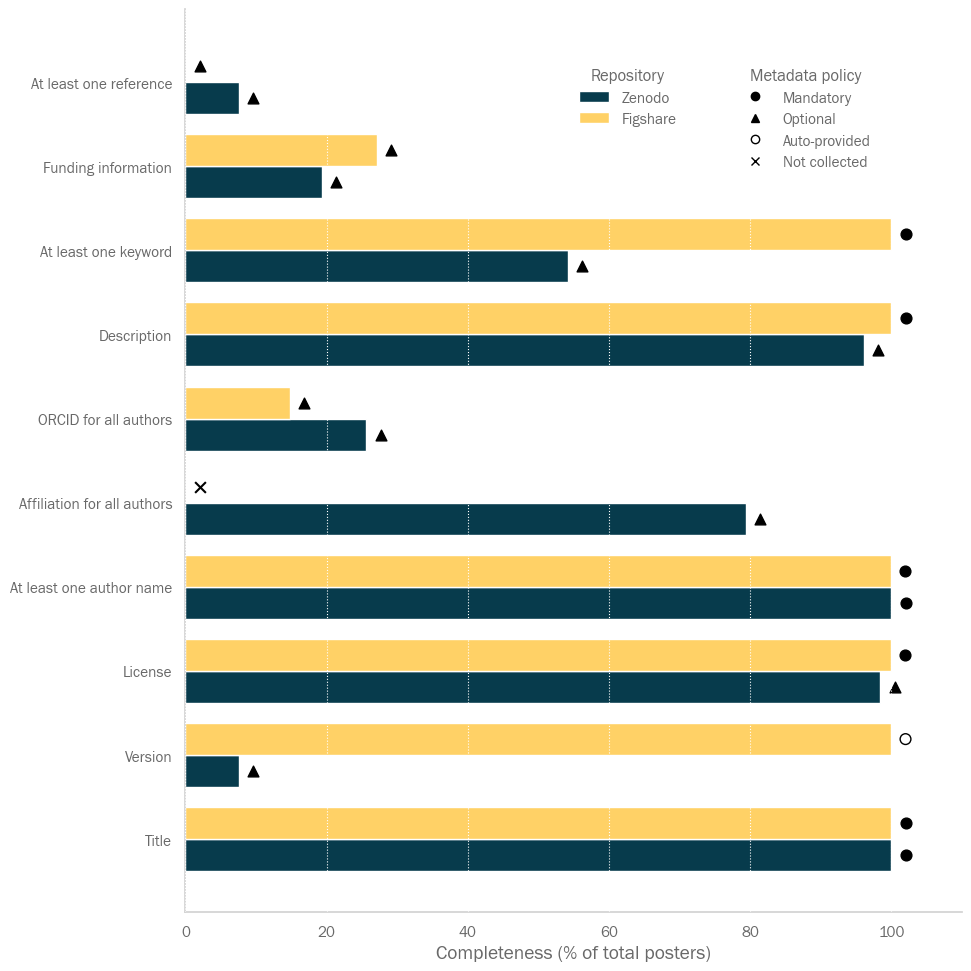

In [40]:
def policy_marker(policy):
    if policy == "mandatory":
        return dict(marker="o", facecolors="black", edgecolors="black")
    if policy == "auto":
        return dict(marker="o", facecolors="none", edgecolors="black") 
    if policy == "not_collected":
        return dict(marker="x", facecolors="black")
    return dict(marker="^", facecolors="black", edgecolors="black")  

def plot_metadata_completeness(df, zenodo_policy, figshare_policy):
    labels = df["Metadata"].tolist()
    z = df["Zenodo"].to_numpy()
    f = df["Figshare"].to_numpy()

    x = np.arange(len(labels))
    width = 0.38

    fig, ax = plt.subplots(figsize=(10, 10))

    # bars
    bz = ax.barh(x - width/2, z, width, label="Zenodo", color = colors[0])
    bf = ax.barh(x + width/2, f, width, label="Figshare", color = colors[1])

    # policy markers
    ypad = 2.0  # % points above bar

    for i, m in enumerate(labels):
        # Zenodo marker
        pz = zenodo_policy.get(m, "optional")
        stylez = policy_marker(pz)
        ax.scatter(min(z[i] + ypad, 102), x[i] - width/2, s=60, **stylez)

        # Figshare marker
        pf = figshare_policy.get(m, "optional")
        stylef = policy_marker(pf)
        ax.scatter(min(f[i] + ypad, 102), x[i] + width/2, s=60, **stylef)

    ax.set_xlim(0, 110)
    ax.set_xlabel("Completeness (% of total posters)", fontsize = 14)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)

    # Repo legend
    bar_legend = ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.65, 0.95),
        title="Repository",
        frameon=False
    )
    ax.add_artist(bar_legend)

    # Policy legend
    from matplotlib.lines import Line2D
    marker_handles = [
        Line2D([0], [0], marker='o', color='black', linestyle='None',
               markerfacecolor='black', label='Mandatory'),
        Line2D([0], [0], marker='^', color='black', linestyle='None',
               markerfacecolor='black', label='Optional'),
        Line2D([0], [0], marker='o', color='black', linestyle='None',
               markerfacecolor='none', label='Auto-provided'),
        Line2D([0], [0], marker='x', color='black', linestyle='None',
               label='Not collected'),
    ]
    ax.legend(handles=marker_handles, loc="center right", title="Repository policy")
    ax.legend(
        handles=marker_handles,
        loc="upper right",
        bbox_to_anchor=(0.9, 0.95),
        title="Metadata policy",
        frameon=False
    )
    ax.grid(axis="x", linestyle=":", linewidth=0.8)
    
    fig.tight_layout()
    return fig, ax


fig, ax = plot_metadata_completeness(df_general_metadata, zenodo_policy, figshare_policy)
plt.savefig('outputs/poster-metadata/completeness.png') 
plt.show()

### Completeness of conference related metadata on Zenodo

Only for Zenodo

In [41]:
conference_metadata_results_list = []

conference_cols = [
    "has_conference_acronym",
    "has_conference_dates",
    "has_conference_place",
    "has_conference_session",
    "has_conference_session_part",
    "has_conference_title",
    "has_conference_website",
]

repository_list = ["Zenodo"] # Only doing this for Zenodo
repository_list_loop = [[x] for x in repository_list]

# Conference name is provided
repo_metadata = ["Conference name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_title"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference acronym is provided
repo_metadata = ["Conference acronym"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_acronym"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference dates are provided
repo_metadata = ["Conference dates"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_dates"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference location is provided
repo_metadata = ["Conference location"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_place"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference website is provided
repo_metadata = ["Conference website"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_website"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference session of the poster is provided
repo_metadata = ["Conference session related to the poster"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["has_conference_session"] == True)
                | (df_sub["has_conference_session_part"] == True)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# At least one conference-related metadata is provided
df["has_any_conference_metadata"] = df[conference_cols].any(axis=1)
repo_metadata = ["Any conference-related metadata"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_any_conference_metadata"] == True])/ len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# All conference-related metadata is provided
df["has_all_conference_metadata"] = df[conference_cols].all(axis=1)
repo_metadata = ["All conference-related metadata"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_all_conference_metadata"] == True])/ len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

df_conference_metadata = pd.DataFrame(
    conference_metadata_results_list, columns=["Metadata"] + repository_list
)
display(df_conference_metadata)

,Metadata,Zenodo
0,Conference name,47.084966
1,Conference acronym,27.259505
2,Conference dates,44.854753
3,Conference location,40.935720
4,Conference website,37.347986
5,Conference session related to the poster,13.696416
6,Any conference-related metadata,47.557674
7,All conference-related metadata,1.591855


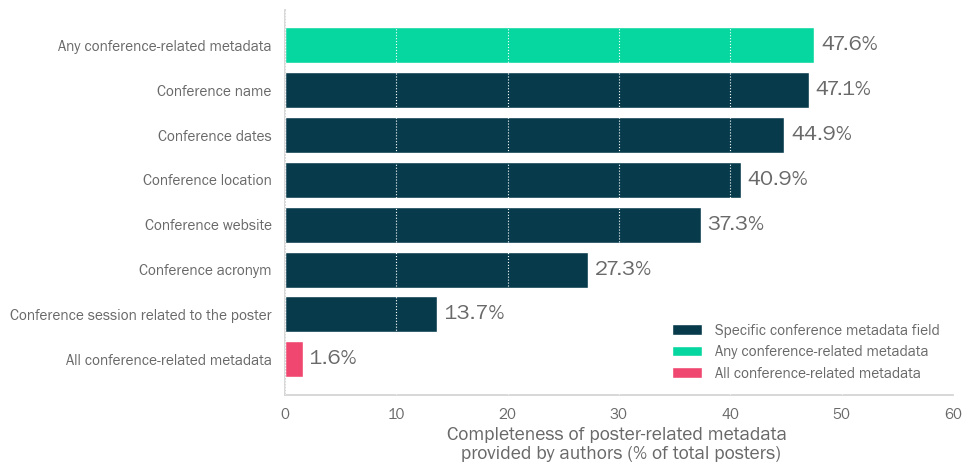

In [42]:
def plot_conference_metadata_zenodo(df_conf):
    dfp = df_conf.copy()

    # Sort by percentage
    dfp = dfp.sort_values("Zenodo", ascending=True).reset_index(drop=True)

    # Rows to highlight with different color
    is_any = dfp["Metadata"].str.strip().eq("Any conference-related metadata")
    is_all = dfp["Metadata"].str.strip().eq("All conference-related metadata")

    # Colors
    base_color = colors[0]      
    any_color = colors[2]       
    all_color = colors[4]      
    colors_assigned = []
    for m in dfp["Metadata"]:
        if m == "Any conference-related metadata":
            colors_assigned.append(any_color)
        elif m == "All conference-related metadata":
            colors_assigned.append(all_color)
        else:
            colors_assigned.append(base_color)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(dfp["Metadata"], dfp["Zenodo"], color=colors_assigned)

    # Add value at the end of bars
    for y, v in enumerate(dfp["Zenodo"].values):
        ax.text(v + 0.6, y, f"{v:.1f}%", va="center")
    
    # Axis
    ax.set_xlim(0, 60)
    ax.set_xlabel("Completeness of poster-related metadata \n provided by authors (% of total posters)",
                 fontsize = 14)

    # Light vertical grid lines over bars
    ax.grid(axis="x", linestyle=":", linewidth=0.8)

    # Legend
    legend_handles = [
    Patch(facecolor=base_color, label="Specific conference metadata field"),
    Patch(facecolor=any_color, label="Any conference-related metadata"),
    Patch(facecolor=all_color, label="All conference-related metadata"),
    ]
    ax.legend(handles=legend_handles, loc="lower right", frameon=False)

    fig.tight_layout()
    return fig, ax

fig, ax = plot_conference_metadata_zenodo(df_conference_metadata)
plt.savefig('outputs/poster-metadata/completeness-conference.png') 
plt.show()